# Predicting diabetes with a simple neural network using Keras

## Supressing warnings

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Importing libraries

In [2]:
!pip install pydot
!pip install graphviz


In [3]:
import h5py as h5
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense
import numpy as np

import os
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

C:\Users\zscho\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load the dataset

In [4]:
data = pd.read_csv("pima-indians-diabetes.csv", names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'PedigreeFunction', 'Age', 'Outcome'])


In [5]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Data statistics

In [6]:
#  check for nulls 
a = data.isnull().sum()
b = a.sort_values(ascending=False)
b.head()

Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
dtype: int64

In [7]:
# view the dataset description
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Create the pairplot using seaborn library

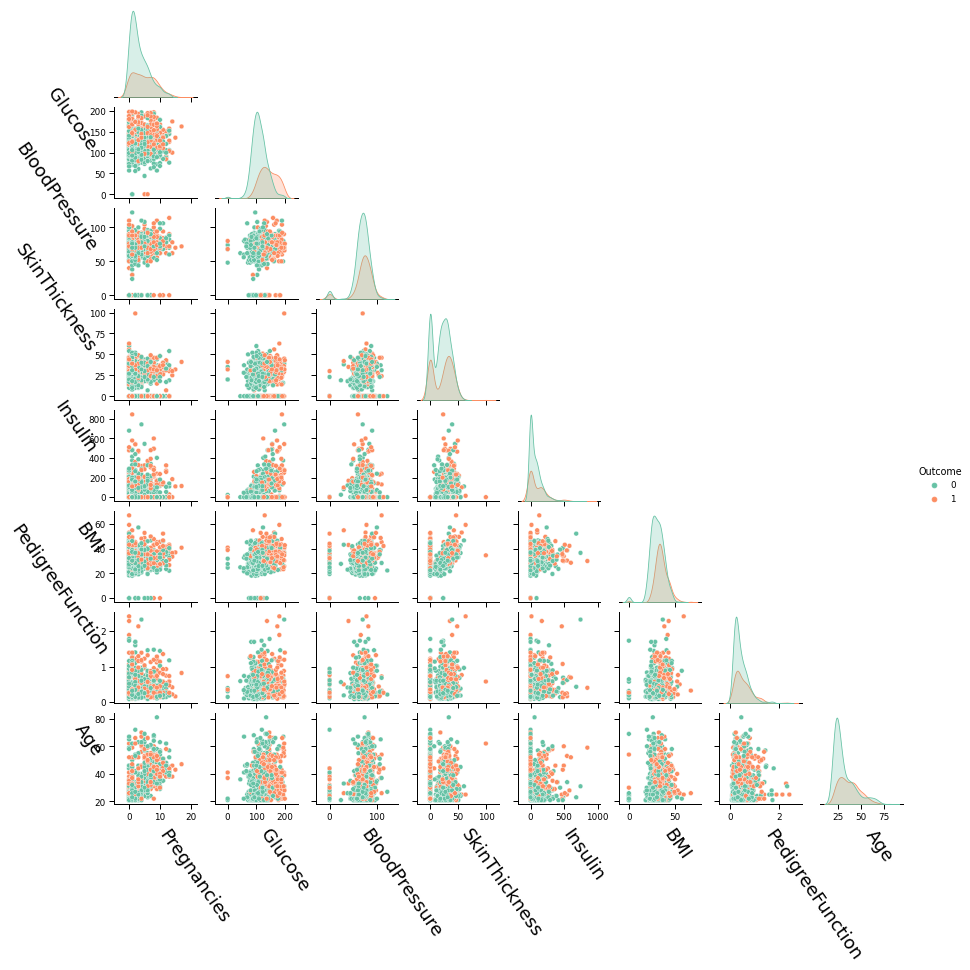

In [8]:
# seaborn pairplot
sns.set_context("paper", rc={"axes.labelsize":18})
plot = sns.pairplot(data, hue = 'Outcome', palette= 'Set2', corner=True, height=1.5)
for ax in plot.axes.flatten():
    if ax:
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation = -55, horizontalalignment='left')
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation = -55, horizontalalignment='right')

## Missing value handling

In [9]:
# num of missing vals
data_copy = data.copy()


for c in ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Glucose']:
  data_copy[c].replace(to_replace = 0, value = np.nan, inplace=True)
  
data_copy.isnull().sum()

Pregnancies           0
Glucose               5
BloodPressure        35
SkinThickness       227
Insulin             374
BMI                  11
PedigreeFunction      0
Age                   0
Outcome               0
dtype: int64

In [10]:
# medians in columns that dont have max # of missing values
for c in ['BloodPressure', 'BMI', 'SkinThickness', 'Insulin']:
      data[c].replace(to_replace = 0, value = data[c].median(), inplace=True)

In [11]:
# replace zeros in column

from sklearn import linear_model

for metric in ["Glucose"]:
    X = data[data[metric] != 0]
    X = X.drop(columns = [metric])
    y = data.loc[data[metric] != 0, metric]
    print("Training: ", metric, X.shape, y.shape)
    model = linear_model.LinearRegression()
    model.fit(X, y)
    X_miss = data[data[metric] == 0]
    X_miss = X_miss.drop(columns = [metric])
    print("missing values:", X_miss.shape)
    data.loc[data[metric] == 0, metric] = model.predict(X_miss)

Training:  Glucose (763, 8) (763,)
missing values: (5, 8)


## Handling Skewness and Feature Scaling

In [12]:
for feature in ['SkinThickness', 'Insulin', 'BMI', 'Age']:
    data[feature] = np.log(data[feature])

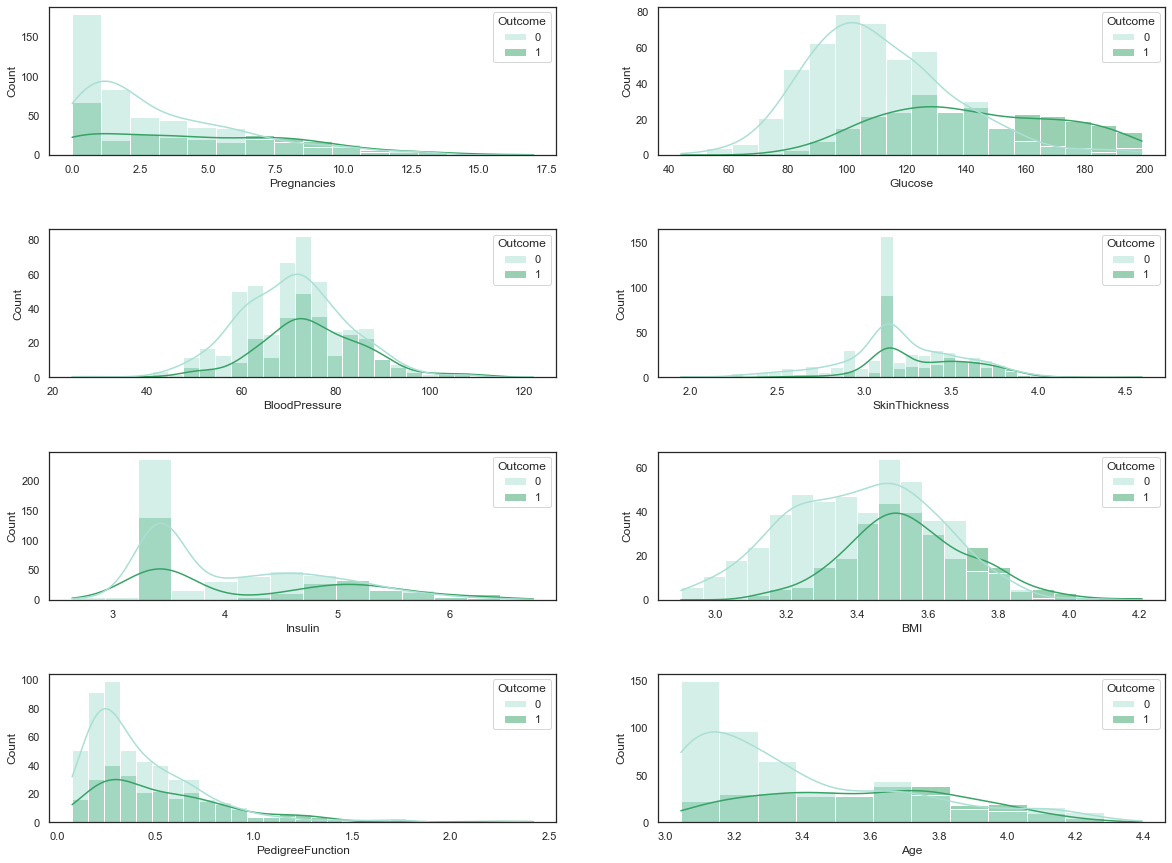

In [13]:
# plot distros 
feature_names = list(data.columns)[:8]
rcParams['figure.figsize'] = 20,15
sns.set(font_scale = 1)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(4,2,i)
    sns.histplot(data=data, x=name, hue="Outcome",kde=True,palette="BuGn")
    i = i + 1

In [14]:
# scale
scaler = StandardScaler()
train_data = data.to_numpy()
train_data[:, :8] = scaler.fit_transform(train_data[:, :8])

##  Feature Selection

<AxesSubplot:>

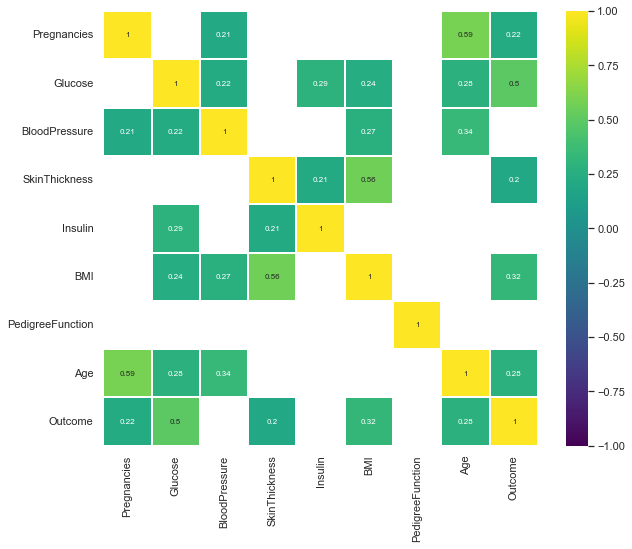

In [15]:
# plot heatmap
corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr[(corr >= 0.2) | (corr <= -0.2)],
cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
annot=True, annot_kws={"size": 8}, square=True)

## Dataset Splitting

In [16]:
# gen dataset splits
from sklearn.model_selection import train_test_split
X = train_data[:, [0, 1, 5, 7]]
Y = pd.get_dummies(train_data[:, 8])
X_train, X_assess, Y_train, Y_assess = train_test_split(X, Y, test_size=0.4, random_state=10)
X_val, X_test, Y_val, Y_test = train_test_split(X_assess, Y_assess, test_size=0.5, random_state=10)
print("Y_train, Y_val, Y_test ", Y_train.shape, Y_val.shape, Y_test.shape )
print("X_train, X_val, X_test ", X_train.shape, X_val.shape, X_test.shape)

Y_train, Y_val, Y_test  (460, 2) (154, 2) (154, 2)
X_train, X_val, X_test  (460, 4) (154, 4) (154, 4)


## Creating a neural network model

In [17]:
# create the model
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

## Model Training

In [18]:
#compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# train
h = model.fit(X_train, Y_train, epochs=40, validation_data=(X_val, Y_val), batch_size=32, verbose=1)

Epoch 1/40
15/15 [==============================] - 1s 14ms/step - loss: 0.7085 - accuracy: 0.4478 - val_loss: 0.6928 - val_accuracy: 0.5974
Epoch 2/40
15/15 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.6043 - val_loss: 0.6763 - val_accuracy: 0.6364
Epoch 3/40
15/15 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.6522 - val_loss: 0.6622 - val_accuracy: 0.6623
Epoch 4/40
15/15 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6717 - val_loss: 0.6504 - val_accuracy: 0.6688
Epoch 5/40
15/15 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6717 - val_loss: 0.6391 - val_accuracy: 0.6753
Epoch 6/40
15/15 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6717 - val_loss: 0.6280 - val_accuracy: 0.6753
Epoch 7/40
15/15 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6674 - val_loss: 0.6172 - val_accuracy: 0.6818
Epoch 8/40
15/15 [=

In [20]:
scores = model.evaluate(X_test, Y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

5/5 [==============================] - 0s 2ms/step - loss: 0.4708 - accuracy: 0.7662
accuracy: 76.62%


In [21]:
#serialize model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [22]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Printing the training curves

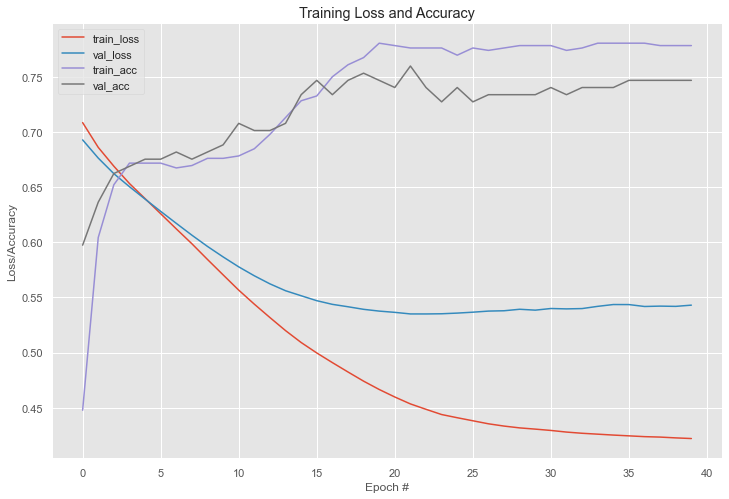

In [23]:
# plot train and valid accuracies/losses
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 40)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, h.history["loss"], label="train_loss")
plt.plot(N, h.history["val_loss"], label="val_loss")
plt.plot(N, h.history['accuracy'], label="train_acc")
plt.plot(N, h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Confusion Matrix

In [24]:
# predicitions
actuals = np.argmax([Y_test.T], axis=1)[0]
Y_predicted = model.predict(X_test)
classes= np.argmax(Y_predicted,axis=1)

5/5 [==============================] - 0s 1ms/step


Text(12.5, 0.5, 'True')

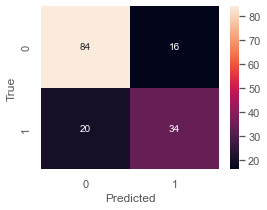

In [25]:
# create matrix
cm = confusion_matrix(actuals, classes)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

## Compute classification metrics

In [26]:
#print report
target_names = ['Diabetes', "No-Diabetes"]
print(classification_report(actuals, classes, target_names=target_names))

              precision    recall  f1-score   support

    Diabetes       0.81      0.84      0.82       100
 No-Diabetes       0.68      0.63      0.65        54

    accuracy                           0.77       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154

